<a href="https://colab.research.google.com/github/nilberthsouza/Synthetic-Financial-Datasets-For-Fraud-Detection/blob/master/edaTheseAndModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report

#!pip install --upgrade pandas
!pip install category_encoders
from category_encoders.one_hot import OneHotEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 81kB 2.2MB/s 


In [2]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/synt.csv")
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [0]:
cashoutOcurrency  = df['type'][df['type'] == 'CASH_OUT'].value_counts()/df.shape[0]
trasnferOcurrency = df['type'][df['type'] == 'TRANSFER'].value_counts()/df.shape[0]
cashinOcurrency   = df['type'][df['type'] == 'CASH_IN'].value_counts()/df.shape[0]
debitOcurrency    = df['type'][df['type'] == 'DEBIT'].value_counts()/df.shape[0]


In [5]:
df['varoldbalanceOrg'] = df.amount/df['oldbalanceOrg']
df['varoldbalanceDest'] = df.amount/df['oldbalanceDest']


df.varoldbalanceOrg.fillna(1,inplace=True)
df.varoldbalanceDest.fillna(1,inplace=True)

#certifica que celulas não fiquem com valor inf 
df.varoldbalanceOrg = df.varoldbalanceOrg.map(lambda a: 1 if a == np.inf else a)
df.varoldbalanceDest = df.varoldbalanceDest.map(lambda a: 1 if a == np.inf else a)

df.dropna(inplace=True)
df.isnull().sum()

step                 0
type                 0
amount               0
nameOrig             0
oldbalanceOrg        0
newbalanceOrig       0
nameDest             0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
varoldbalanceOrg     0
varoldbalanceDest    0
dtype: int64

In [0]:
df.loc[df['type'] == 'CASH_OUT'].shape[0]

2237500

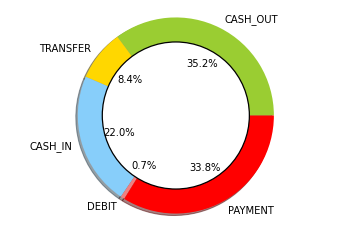

In [6]:
cashoutOcurrency  = df.loc[df['type'] == 'CASH_OUT'].shape[0]/df.shape[0]
trasnferOcurrency = df.loc[df['type'] == 'TRANSFER'].shape[0]/df.shape[0]
cashinOcurrency   = df.loc[df['type'] == 'CASH_IN'].shape[0]/df.shape[0]
debitOcurrency    = df.loc[df['type'] == 'DEBIT'].shape[0]/df.shape[0]
paymentOcurrency    = df.loc[df['type'] == 'PAYMENT'].shape[0]/df.shape[0]

labels = 'CASH_OUT', 'TRANSFER', 'CASH_IN', 'DEBIT','PAYMENT'
sizes = [cashoutOcurrency, trasnferOcurrency,cashinOcurrency, debitOcurrency,paymentOcurrency]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','red']

explode = (0, 0, 0, 0,0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
        
#desenha um circulo no meio do piechart
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.axis('equal')
plt.show()  

In [0]:

df.drop(['step','nameOrig','nameDest'],axis=1,inplace=True)

In [0]:
enc = OneHotEncoder(cols=['type'], use_cat_names=True)
enc.fit(df)
df = enc.transform(df)


In [9]:
df.head()

,type_PAYMENT,type_TRANSFER,type_CASH_OUT,type_DEBIT,type_CASH_IN,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,varoldbalanceOrg,varoldbalanceDest
0,1,0,0,0,0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.057834,1.000000
1,1,0,0,0,0,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.087735,1.000000
2,0,1,0,0,0,181.00,181.0,0.00,0.0,0.0,1,0,1.000000,1.000000
3,0,0,1,0,0,181.00,181.0,0.00,21182.0,0.0,1,0,1.000000,0.008545
4,1,0,0,0,0,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.280795,1.000000


In [33]:
from scipy import stats

#stats.normaltest(df.amount)

stats.fligner(df.amount)

ValueError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


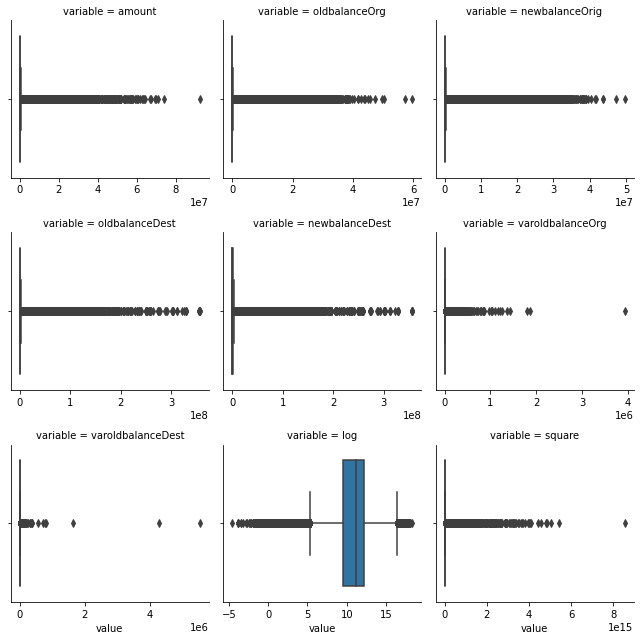

In [29]:
numerical = df.drop(['type_PAYMENT','type_TRANSFER','type_CASH_OUT','type_DEBIT','type_CASH_IN','isFraud','isFlaggedFraud'],axis=1).columns

f = pd.melt(df, value_vars=numerical)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


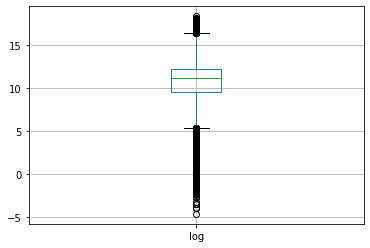

In [14]:
teste = df
teste['log'] = np.log(df.amount)
teste.boxplot(['log'])

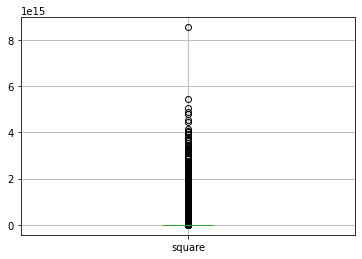

In [15]:
teste['square'] = np.square(df.amount)
teste.boxplot(['square'])

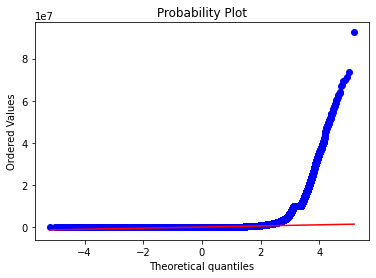

In [16]:
!pip install pylab
import pylab 

stats.probplot(df.amount, dist="norm", plot=pylab)
pylab.show()

#Explorar mais em https://www.statsmodels.org/devel/generated/statsmodels.graphics.gofplots.qqplot.html

In [0]:
import time
start = time.time()

df['maiormenor'] = 0
maxminvalue = df.amount[df.isFraud == 1].max()
minvalue = df.amount.min()



for i in range(df.shape[0]):
  if df.loc[i,'amount'] < (maxminvalue + minvalue):
    df.loc[i,'maiormenor'] = 1
  else:
    df.loc[i,'maiormenor'] =0


end = time.time()
print(end-start)


In [0]:
df = df.sample(frac=1)
df = df.sample(frac=1)
df = df.sample(frac=1)
df.reset_index(inplace=True)
X_train, X_test , y_train, y_test = train_test_split(df.drop(['isFraud'],axis=1),df['isFraud'],test_size=0.3, random_state=0)

print(len(X_train),len(X_test),len(y_train),len(y_test))

In [0]:
df = df.sample(frac=1)
df = df.sample(frac=1)
df = df.sample(frac=1)
df.reset_index(inplace=True)
X_train, X_test , y_train, y_test = train_test_split(df.drop(['isFraud'],axis=1),df['isFraud'],test_size=0.3, random_state=0)

print(len(X_train),len(X_test),len(y_train),len(y_test))



In [0]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(), annot=True, cmap="Blues")

In [0]:
X_train.hist(figsize=(10,8))

In [0]:
sns.scatterplot(x = train.oldbalanceDest,y=train.newbalanceDest,hue=df.isFraud)


In [0]:
sns.scatterplot(x=df['varoldbalanceOrg'],y=df['varoldbalanceDest'],hue=df.isFraud)

In [0]:

model = LogisticRegression()
model.fit(X_train,y_train)

modelOnePredictions = model.predict(X_test)



classification_report( y_test, modelOnePredictions)

In [0]:


accuracy_score(y_test,modelOnePredictions)